The data source is a Garmin Bike Computer   
The source columns are:  
* time
* distance_diff
* time_diff
* speed
* moving
* breaks

The transformation related to time are
* adding timezone data to source data
* converting times to Dublin Time Zone
* producing a true time series with constant time interval of 1 second

## Setups

In [3]:
#Import Python Libraries

%matplotlib inline
import matplotlib.pyplot as plt
import xml.etree.ElementTree as etree 
from datetime import datetime, timedelta
import os
import json
import pandas as pd
import numpy as np
from pytz import common_timezones, all_timezones, timezone

In [4]:
# Define name and path of data file
# This data file contains a sub-set of activiy information relating to speed and time

input_file = 'activity_speed.csv'
input_dir = os.path.join("/", "opt","jupyter","data","csv" )

input_file_path = os.path.join(input_dir , input_file)

print ("Input file is (full path)  ", input_file_path)

Input file is (full path)   /opt/jupyter/data/csv/activity_speed.csv


In [6]:
# Load data file into a Pandas data frame for inspection
# The dataframe is indexed on time - time variant data
df = pd.read_csv(input_file_path, index_col = 'time',  parse_dates=True)



# rename the speed column to speed_raw
df.rename( columns = {"speed":"speed_raw"} , inplace=True)
#check column names
df.columns

Index(['distance_diff', 'time_diff', 'speed_raw', 'moving', 'breaks'], dtype='object')

## Handle Time Zones

In [7]:
# Define timezone of source data
tz_source = 'UTC'
# Set source timezone data
df = df.tz_localize( tz_source )

In [9]:
# Define target time_zone
tz_local = timezone('Europe/Dublin')
# Convert data frame to desired Time Zone
df = df.tz_convert(tz_local  )
df.head()

,distance_diff,time_diff,speed_raw,moving,breaks
time,,,,,
2015-09-13 07:25:51+01:00,0.000000,1,0.0,False,False
2015-09-13 07:25:56+01:00,23.080000,5,16.6,True,False
2015-09-13 07:25:57+01:00,6.650002,1,23.9,True,False
2015-09-13 07:26:00+01:00,5.910000,3,7.1,True,False
2015-09-13 07:26:03+01:00,11.439999,3,13.7,True,False


## Exploring the Imported Data Set

The fitness data consists of a set of data points whose values vary in time.
The data is a sequence in time order.

Each data point relates to a different point in time and contains the following variables:
* distince_diff - the distance travelled since the last data point
* time_diff - the number of seconds that have elapsed since the last data point
* speed_raw - measured in km/hr, calculated using formula (distance_diff / time_diff) * 3.6
* moving - if the data point represents movement then True.  If the user is at rest then False
* breaks - Set to True if the using is at rest and taking a break from activity

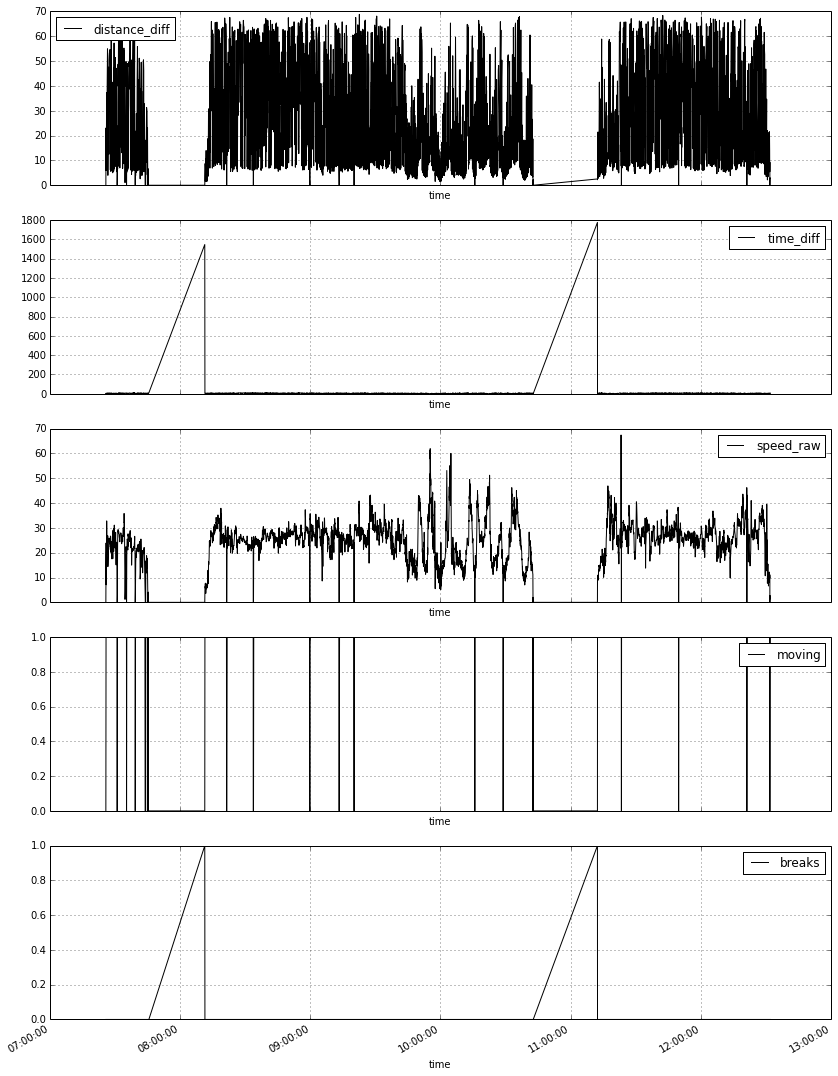

In [30]:
#plot all columns
_ = df.plot(subplots=True, 
        figsize=(14, 20),
         xlim=(datetime(2015,9,13,6,0,0 ),datetime(2015,9,13,12,0,0  )),
        )

In [37]:
# get statistical summary
df.describe()

,distance_diff,time_diff,speed_raw,moving,breaks
count,5358.000000,5358.000000,5358.000000,5358,5358
mean,19.660904,3.428891,25.820063,0.9925345,0.0003732736
std,18.063191,32.195810,9.102339,0.08608787,0.01931849
min,0.000000,1.000000,0.000000,False,False
25%,6.931396,1.000000,20.300000,1,0
50%,11.113281,1.000000,25.900000,1,0
75%,28.084473,4.000000,30.800000,1,0
max,68.839844,1775.000000,67.400000,True,True


## Exploring the Time Interval between Data Points

Inspection of the first few rows shows that the data is time indexed.   
The time_diff column shows that the intervals between data points are whole seconds.    
The time interval between data points is not fixed - irregular interval between data points
For example there are 5 seconds between first and second data points.

In [10]:
# view first few rows 
df.head()

,distance_diff,time_diff,speed_raw,moving,breaks
time,,,,,
2015-09-13 07:25:51+01:00,0.000000,1,0.0,False,False
2015-09-13 07:25:56+01:00,23.080000,5,16.6,True,False
2015-09-13 07:25:57+01:00,6.650002,1,23.9,True,False
2015-09-13 07:26:00+01:00,5.910000,3,7.1,True,False
2015-09-13 07:26:03+01:00,11.439999,3,13.7,True,False


The histogram below shows that most common time interval between data points is 1 second. However many data points have multiple seconds between data points.

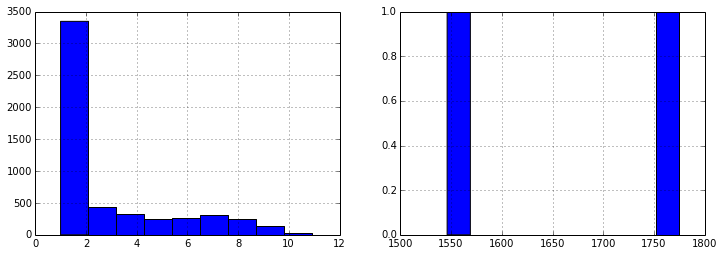

In [11]:
# plotting the time interval betwe

plt.figure() 
plt.subplot(1,2,1)
_ = df['time_diff'][df['time_diff'] < 600].hist(figsize=(12,4))
plt.subplot(1,2,2)
_ = df['time_diff'][df['time_diff'] > 600].hist(figsize=(12,4))

## Transforming the Data Set to a Time Series
In this section a new dataframs is constructed with a constant frequency of 1 second.   
In the new dataframe there is exactly 1 second between all data points.
There are no missing data points - a row is generated for every second from start to end time

In [12]:
# create a new dataframe from original dataframe with a constant frequency of one second
time_series = df.asfreq(freq='S', )
time_series.head(10)

,distance_diff,time_diff,speed_raw,moving,breaks
2015-09-13 07:25:51+01:00,0.000000,1,0.0,False,False
2015-09-13 07:25:52+01:00,NaN,NaN,NaN,NaN,NaN
2015-09-13 07:25:53+01:00,NaN,NaN,NaN,NaN,NaN
2015-09-13 07:25:54+01:00,NaN,NaN,NaN,NaN,NaN
2015-09-13 07:25:55+01:00,NaN,NaN,NaN,NaN,NaN
2015-09-13 07:25:56+01:00,23.080000,5,16.6,True,False
2015-09-13 07:25:57+01:00,6.650002,1,23.9,True,False
2015-09-13 07:25:58+01:00,NaN,NaN,NaN,NaN,NaN
2015-09-13 07:25:59+01:00,NaN,NaN,NaN,NaN,NaN
2015-09-13 07:26:00+01:00,5.910000,3,7.1,True,False


In [13]:
time_series.moving.fillna(method = 'bfill', inplace=True)
time_series.breaks.fillna(method = 'bfill', inplace=True)
time_series.head(10)

,distance_diff,time_diff,speed_raw,moving,breaks
2015-09-13 07:25:51+01:00,0.000000,1,0.0,False,False
2015-09-13 07:25:52+01:00,NaN,NaN,NaN,True,False
2015-09-13 07:25:53+01:00,NaN,NaN,NaN,True,False
2015-09-13 07:25:54+01:00,NaN,NaN,NaN,True,False
2015-09-13 07:25:55+01:00,NaN,NaN,NaN,True,False
2015-09-13 07:25:56+01:00,23.080000,5,16.6,True,False
2015-09-13 07:25:57+01:00,6.650002,1,23.9,True,False
2015-09-13 07:25:58+01:00,NaN,NaN,NaN,True,False
2015-09-13 07:25:59+01:00,NaN,NaN,NaN,True,False
2015-09-13 07:26:00+01:00,5.910000,3,7.1,True,False


In [14]:
time_series['speed_raw_ts'] = float(0)
time_series['distance_ts'] = float(0)

In [15]:
num_rows = len( time_series[ (time_series.time_diff.notnull() )] )
for i in range( num_rows ):
    row = time_series[ (time_series.time_diff.notnull() )].iloc[i] 
    row_time = row.name
    if row.breaks == False:
        start_time = row_time - timedelta(seconds = ( int(row.time_diff) - 1))
        new_dist = ( row.distance_diff / int(row.time_diff) ) 
        time_series[ start_time:row_time ].distance_ts = new_dist
        time_series[ start_time:row_time ].speed_raw_ts = new_dist * 3.6

In [16]:
time_series.head(10)

,distance_diff,time_diff,speed_raw,moving,breaks,speed_raw_ts,distance_ts
2015-09-13 07:25:51+01:00,0.000000,1,0.0,False,False,0.000000,0.000000
2015-09-13 07:25:52+01:00,NaN,NaN,NaN,True,False,16.617600,4.616000
2015-09-13 07:25:53+01:00,NaN,NaN,NaN,True,False,16.617600,4.616000
2015-09-13 07:25:54+01:00,NaN,NaN,NaN,True,False,16.617600,4.616000
2015-09-13 07:25:55+01:00,NaN,NaN,NaN,True,False,16.617600,4.616000
2015-09-13 07:25:56+01:00,23.080000,5,16.6,True,False,16.617600,4.616000
2015-09-13 07:25:57+01:00,6.650002,1,23.9,True,False,23.940005,6.650002
2015-09-13 07:25:58+01:00,NaN,NaN,NaN,True,False,7.092000,1.970000
2015-09-13 07:25:59+01:00,NaN,NaN,NaN,True,False,7.092000,1.970000
2015-09-13 07:26:00+01:00,5.910000,3,7.1,True,False,7.092000,1.970000
